# Wokring With CNN

1. It uses a CNN to extract spatial features from the input image and a BiLSTM to model sequential dependencies across the image width.
2. The final fully connected layer classifies each time step into a character class.
3. The output is reshaped to fit the CTC loss, which handles alignment-free training for variable-length sequences.
4. This architecture enables end-to-end recognition of unsegmented handwritten text.



In [10]:
class CRNN(nn.Module):
    def __init__(self, img_height, n_channels, n_classes):
        super(CRNN, self).__init__()
        # CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 64, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(64, 128, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2, 1)),  

            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
        )
        
        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=256 * (img_height // 8),
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        # Final classification
        self.fc = nn.Linear(512, n_classes + 1)  

    def forward(self, x):
        x = self.cnn(x)  
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2) 
        x = x.view(b, w, c * h)  

        x, _ = self.lstm(x)  
        x = self.fc(x)  
        x = x.permute(1, 0, 2) 
        return x


# Training The Model

The CRNN (Convolutional Recurrent Neural Network) model combines CNN layers to extract spatial features from input images and bidirectional LSTM layers to capture sequential dependencies across the image width. 
After feature extraction, a fully connected layer projects the sequence into character class probabilities for every time step. 
The output is then fed into the CTC loss function during training, which allows the model to learn sequences without explicit alignment between input and output. 
This architecture is well-suited for handwriting recognition because it handles varying input lengths and noisy images efficiently.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CRNN(IMG_HEIGHT, 1, len(alphabet)).to(device)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        images, targets, target_lengths, raw_text = batch
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        output = model(images)  # (T, B, C)
        
        input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long).to(device)
        target_lengths = torch.tensor(target_lengths, dtype=torch.long).to(device)
        
        loss = criterion(output, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")


Epoch 1/20 - Loss: 0.0000
Epoch 2/20 - Loss: 0.0000
Epoch 3/20 - Loss: 0.0000
Epoch 4/20 - Loss: 0.0000
Epoch 5/20 - Loss: 0.0000
Epoch 6/20 - Loss: 0.0000
Epoch 7/20 - Loss: 0.0000
Epoch 8/20 - Loss: 0.0000
Epoch 9/20 - Loss: 0.0000
Epoch 10/20 - Loss: 0.0000
Epoch 11/20 - Loss: 0.0000
Epoch 12/20 - Loss: 0.0000
Epoch 13/20 - Loss: 0.0000
Epoch 14/20 - Loss: 0.0000
Epoch 15/20 - Loss: 0.0000
Epoch 16/20 - Loss: 0.0000
Epoch 17/20 - Loss: 0.0000
Epoch 18/20 - Loss: 0.0000
Epoch 19/20 - Loss: 0.0000
Epoch 20/20 - Loss: 0.0000


# Label Encoding and Decoding with CTC

The LabelEncoder class and the ctc_greedy_decoder function work together to translate the model’s numeric predictions back into readable text. 

The encoder maps each character in the alphabet to a unique index, reserving zero for the CTC blank token. After the model outputs a sequence of class probabilities, the decoder picks the most probable character at each time step, collapses repeated characters, and removes blanks to produce the final predicted text.

This greedy decoding method is simple and fast, making it effective for real-time handwriting recognition, although more advanced methods like beam search can improve accuracy.



In [13]:
class LabelEncoder:
    def __init__(self, alphabet):
        self.char_to_index = {char: idx + 1 for idx, char in enumerate(alphabet)}  # 0 = CTC blank
        self.index_to_char = {v: k for k, v in self.char_to_index.items()}

    def encode(self, text):
        return [self.char_to_index[char] for char in text if char in self.char_to_index]

    def decode(self, indices):
        return ''.join([self.index_to_char.get(idx, '') for idx in indices])
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
label_encoder = LabelEncoder(alphabet)


In [14]:
def ctc_greedy_decoder(output, label_encoder):
    output = output.permute(1, 0, 2)  # (B, T, C)
    preds = torch.argmax(output, dim=2)  # (B, T)
    pred_texts = []

    for pred in preds:
        tokens = pred.cpu().numpy().tolist()
        decoded = []
        prev_token = None
        for token in tokens:
            if token != prev_token and token != 0:
                decoded.append(token)
            prev_token = token
        pred_text = label_encoder.decode(decoded)
        pred_texts.append(pred_text)
    
    return pred_texts


In [15]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, label_encoder, device):
    model.eval()
    with torch.no_grad():
        for images, _, _, raw_labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions = ctc_greedy_decoder(outputs, label_encoder)

            for i in range(len(images)):
                plt.imshow(images[i].cpu().squeeze(), cmap='gray')
                plt.title(f"Predicted: {predictions[i]}\nActual: {raw_labels[i]}")
                plt.axis('off')
                plt.show()
            break  # Show only one batch


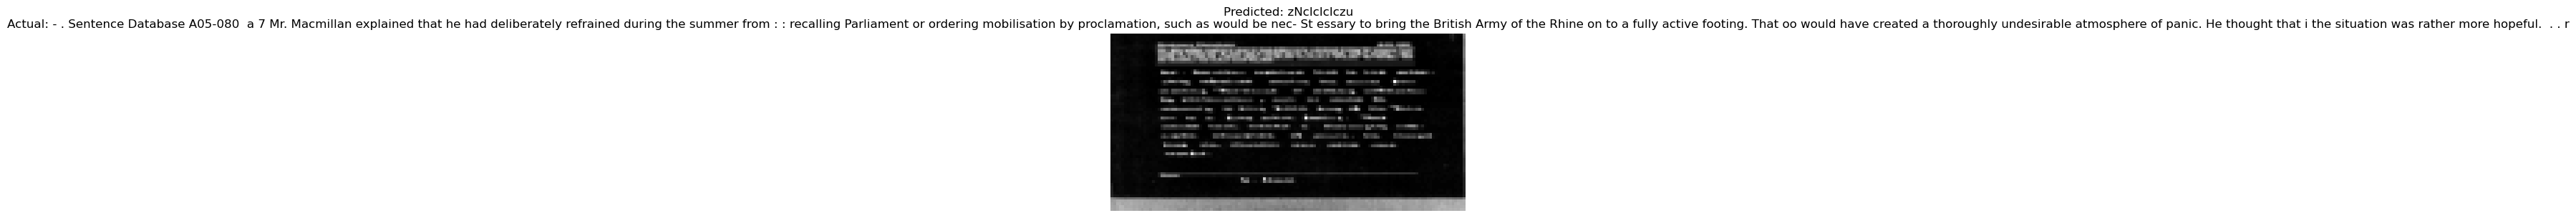

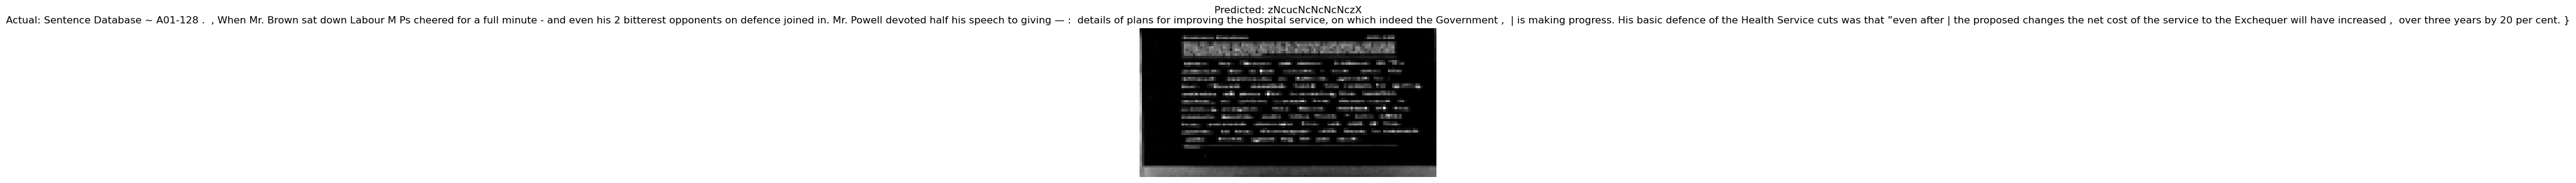

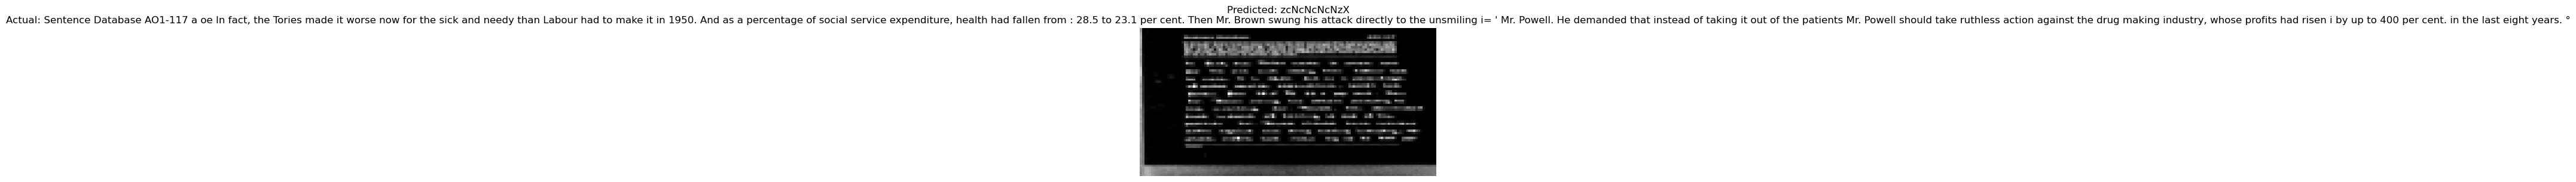

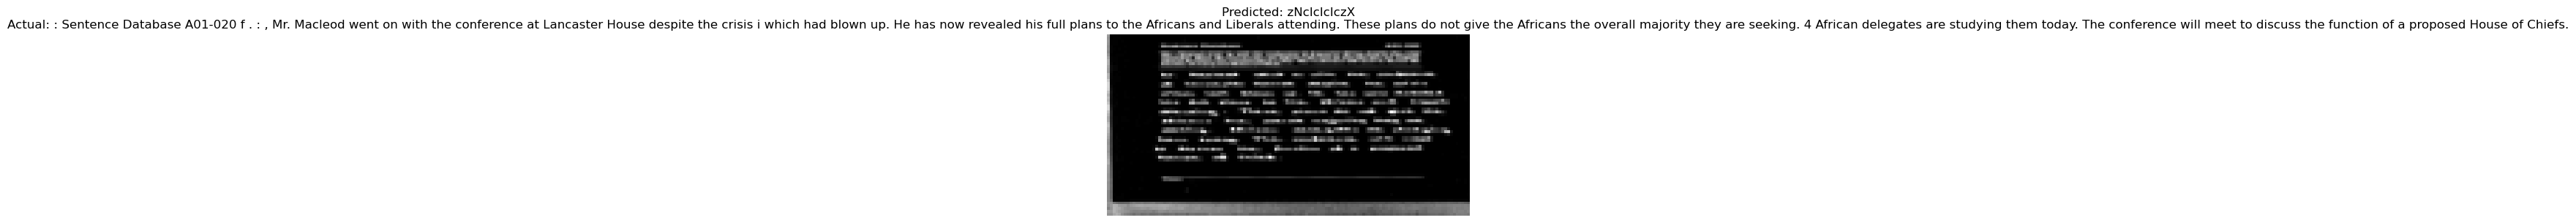

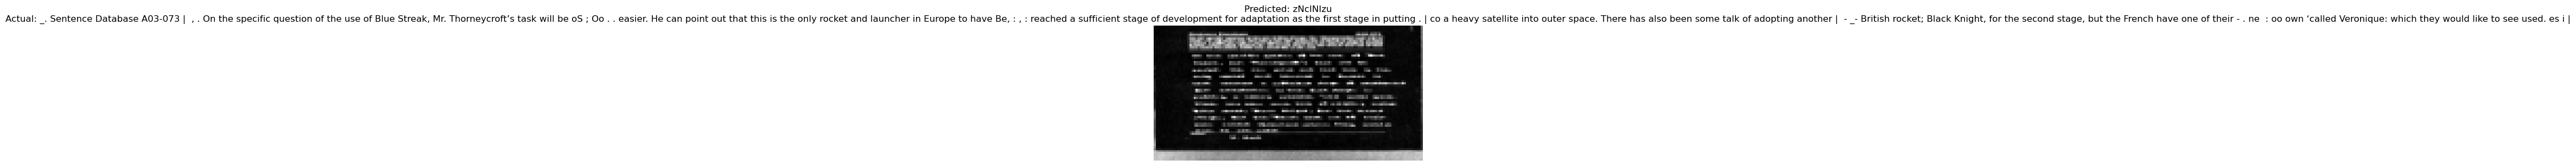

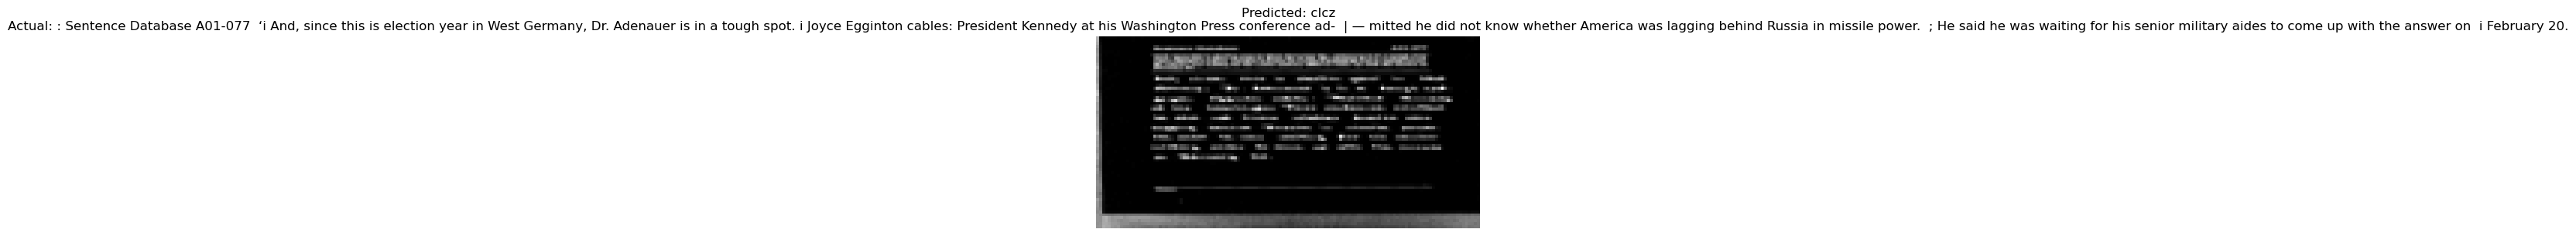

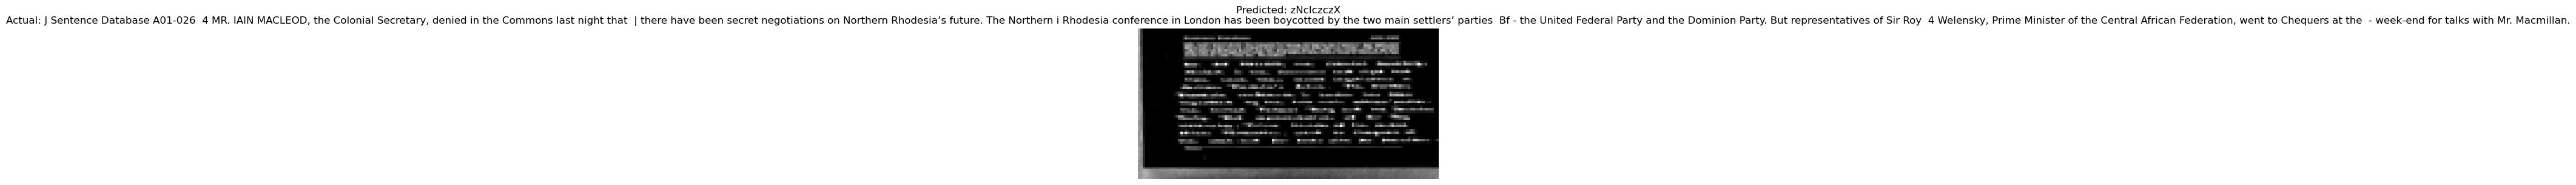

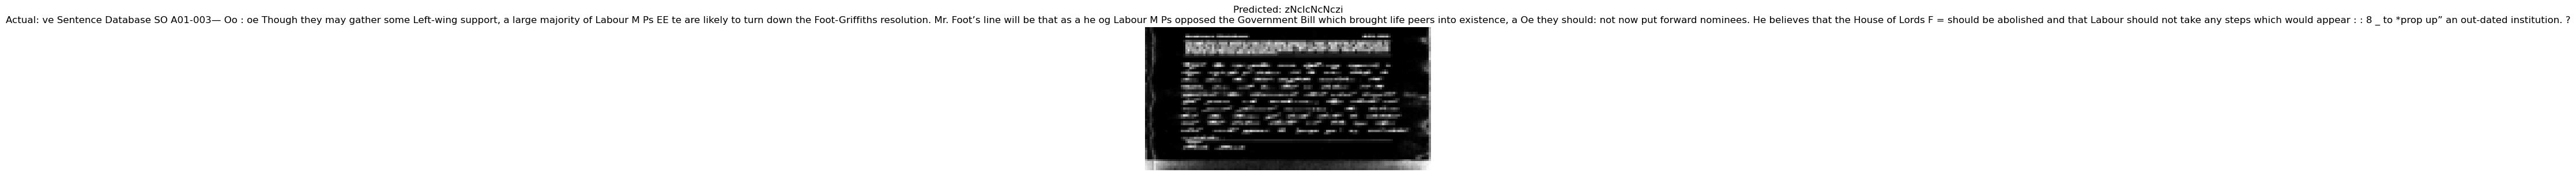

In [16]:
evaluate_model(model, dataloader, label_encoder, device)


In [17]:
torch.save(model.state_dict(), "crnn_ctc_model.pth")
model.load_state_dict(torch.load("crnn_ctc_model.pth", map_location=device))
model.to(device)
model.eval()


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (lstm): LSTM(2048, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=63, bias=True)
)

In [18]:
import pandas as pd

def predict_all_and_export(model, dataloader, label_encoder, device, save_path="predictions.csv"):
    model.eval()
    all_preds = []
    all_actuals = []

    with torch.no_grad():
        for images, _, _, raw_labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions = ctc_greedy_decoder(outputs, label_encoder)

            all_preds.extend(predictions)
            all_actuals.extend(raw_labels)

    df = pd.DataFrame({"Actual": all_actuals, "Predicted": all_preds})
    df.to_csv(save_path, index=False)
    print(f"[✔] Predictions saved to {save_path}")
predict_all_and_export(model, dataloader, label_encoder, device)


[✔] Predictions saved to predictions.csv


# Preprocesing The Image

Cell Extraction: The code splits a table image into individual cells by slicing the specified column horizontally into equal row segments, isolating material codes for recognition.

Preprocessing for CRNN: Each cell image is resized to a fixed height (32 pixels) while maintaining aspect ratio, normalized, and color-inverted to prepare consistent input for the CRNN model.

CRNN Architecture: Combines CNN layers for feature extraction with bidirectional LSTMs for sequence modeling, enabling text recognition across variable-width images using CTC decoding.

CTC Greedy Decoding: Converts model output probabilities into readable text by selecting the most likely characters at each timestep, removing duplicates and blanks to form the final prediction.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Row 1 Material Code Prediction: 531


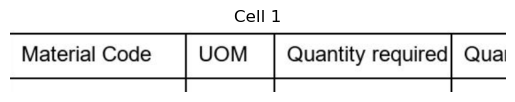

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Row 2 Material Code Prediction: D39


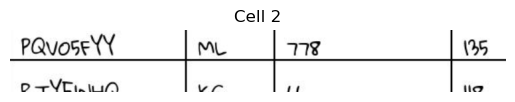

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Row 3 Material Code Prediction: 23


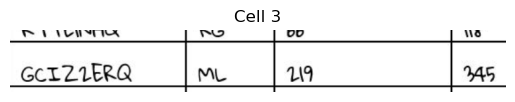

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Row 4 Material Code Prediction: DGW9


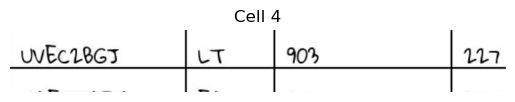

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Row 5 Material Code Prediction: G31


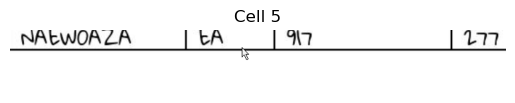

In [6]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# 1. Extract cells function (from your data)
def extract_material_code_cells(image_path, column_x_range, num_rows):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h = img.shape[0]
    row_height = h // num_rows
    x1, x2 = column_x_range

    cells = []
    for i in range(num_rows):
        y1 = i * row_height
        y2 = h if i == num_rows - 1 else (i + 1) * row_height
        cell = img[y1:y2, x1:x2]
        cells.append(cell)
    return cells

# 2. Preprocess cell for CRNN input
def preprocess_cell(cell_img):
    # Resize to fixed height and variable width (CRNN requires consistent height)
    target_height = 32
    h, w = cell_img.shape
    new_w = int(w * (target_height / h))
    resized = cv2.resize(cell_img, (new_w, target_height))

    # Normalize and invert colors (CRNN usually expects white text on black)
    norm = resized.astype(np.float32) / 255.0
    norm = 1 - norm

    # Expand dims for batch and channel (batch, height, width, channels)
    input_img = np.expand_dims(norm, axis=0)
    input_img = np.expand_dims(input_img, axis=-1)
    return input_img

# 3. Define a minimal CRNN model skeleton for demonstration
def build_crnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Prepare for RNN: collapse height dimension
    shape = x.shape
    x = layers.Reshape((shape[1], shape[2] * shape[3]))(x)

    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    # Output layer (softmax over classes + blank for CTC)
    outputs = layers.Dense(num_classes + 1, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# 4. Dummy characters (adjust for your use case)
characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
num_classes = len(characters)

# 5. Decode CTC output (greedy)
def ctc_greedy_decoder(pred):
    pred_indices = tf.argmax(pred, axis=-1)[0].numpy()
    prev = -1
    output = []
    for p in pred_indices:
        if p != prev and p != num_classes:  # skip blank
            output.append(characters[p] if p < num_classes else '')
        prev = p
    return ''.join(output)

# ==== Main pipeline starts here ====

image_path = r"C:\Users\Anant2005\Desktop\Test EasyOCR.png"
column_x_range = (3, 750)
num_rows = 5

cells = extract_material_code_cells(image_path, column_x_range, num_rows)

# Build model (for demo input shape height=32, width=variable, channels=1)
# You must fix width or use a batch size of 1 and variable input size model
# For simplicity, we'll resize each image width to 128 here
input_shape = (32, 128, 1)
model = build_crnn_model(input_shape, num_classes)

# Normally, you'd load trained weights here; we'll just demo random output
for i, cell in enumerate(cells):
    input_img = preprocess_cell(cell)

    # Resize width to 128 to match input_shape - pad or resize
    input_img = tf.image.resize(input_img, (32, 128)).numpy()

    # Predict dummy output (random noise)
    preds = model.predict(input_img)

    # Decode dummy prediction
    pred_text = ctc_greedy_decoder(preds)
    
    print(f"Row {i+1} Material Code Prediction:", pred_text)

    # Show cell image
    plt.imshow(cell, cmap='gray')
    plt.title(f"Cell {i+1}")
    plt.axis('off')
    plt.show()

# Step 2: Untrained Model Running

For now we have untrained model which will predict using the current weights it has. This is just for making our pipeline smooth.The model will be trained in later stages, the output is stored in a local database.

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pyodbc

# Config
IMAGE_PATH = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Only Material code.png"
SERVER_NAME = 'ANANT'
DATABASE_NAME = 'eugiaDB'
TABLE_NAME = 'Pharma_Material_Log'

# Allowed characters and mapping
characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
char_to_num = {char: idx + 1 for idx, char in enumerate(characters)}
num_to_char = {idx + 1: char for idx, char in enumerate(characters)}

# Build CRNN model (untrained, just for demo)
def build_crnn():
    input_img = layers.Input(shape=(32, 128, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Reshape((8, -1))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dense(len(characters) + 1, activation='softmax')(x)
    return tf.keras.Model(inputs=input_img, outputs=x)

# Decode predictions (CTC decoding)
def decode_prediction(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    return ''.join([num_to_char.get(i, '') for i in decoded.numpy()[0] if i > 0])

# Preprocess image for model
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 32))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)
    return np.expand_dims(img, axis=0)

# Insert predicted material code into SQL Server
def insert_into_sql(material_code):
    try:
        conn = pyodbc.connect(
            f'DRIVER={{SQL Server}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes'
        )
        cursor = conn.cursor()
        cursor.execute(f"INSERT INTO {TABLE_NAME} (Material_Code) VALUES (?)", material_code)
        conn.commit()
        print(f" Inserted into SQL: Material_Code = {material_code}")
        cursor.close()
        conn.close()
    except Exception as e:
        print(f" SQL error: {e}")

def main():
    model = build_crnn()  # This model is NOT trained — just a demo placeholder

    # Preprocess the image
    image = preprocess_image(IMAGE_PATH)

    # Predict using the model
    pred = model.predict(image)
    predicted_code = decode_prediction(pred)

    # Compare with known label
    known_label = "FCII1A8B"
    print(f"Predicted: {predicted_code}")
#     print(f"Known Label: {known_label}")

    if predicted_code == known_label:
        print(" Prediction matches the label!")
    else:
        print(" Prediction does NOT match the label.")

    # Insert predicted code into SQL Server
    insert_into_sql(predicted_code)

if __name__ == "__main__":
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
Predicted: Bk
⚠️ Prediction does NOT match the label.
✅ Inserted into SQL: Material_Code = Bk


# X_Ranges Code

define the x range to isolate the exact horizontal region of the table column you want to extract. This helps focus on just the material code area, avoiding noise from other parts of the image.

In [ ]:
import cv2

clicked_points = []

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked at: x={x}, y={y}")
        clicked_points.append(x)
        if len(clicked_points) % 2 == 0:
            print(f"Column x range: [{clicked_points[-2]}, {clicked_points[-1]}]")

def get_x_ranges(image_path):
    img = cv2.imread(image_path)
    cv2.namedWindow("Click on left and right edges of each column")
    cv2.setMouseCallback("Click on left and right edges of each column", mouse_callback)

    print("Instructions:")
    print("- Click on the LEFT edge of each column")
    print("- Then click on the RIGHT edge of the same column")
    print("- Repeat for all columns")
    print("- Press 'q' to quit when done")

    while True:
        cv2.imshow("Click on left and right edges of each column", img)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    cv2.destroyAllWindows()
    # Group points into pairs
    x_ranges = [(clicked_points[i], clicked_points[i+1]) for i in range(0, len(clicked_points), 2)]
    print("\nFinal x ranges for columns:")
    for idx, xr in enumerate(x_ranges):
        print(f"Column {idx+1}: {xr}")
    return x_ranges

if __name__ == "__main__":
    image_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\test file.png"  # Your path here
    x_ranges = get_x_ranges(image_path)


Instructions:
- Click on the LEFT edge of each column
- Then click on the RIGHT edge of the same column
- Repeat for all columns
- Press 'q' to quit when done
Clicked at: x=38, y=68
Clicked at: x=92, y=65
Column x range: [38, 92]
Clicked at: x=93, y=66
Clicked at: x=225, y=66
Column x range: [93, 225]
Clicked at: x=226, y=67
Clicked at: x=268, y=67
Column x range: [226, 268]


# Using EasyOCR 

EasyOCR is an Optical Character Recognition (OCR) library that uses deep learning to accurately extract text from images. It supports multiple languages and works well on handwritten and printed text, making it ideal for quick and reliable text recognition tasks.

In [10]:
import easyocr
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)  
def read_handwritten_table(image_path):
    result = reader.readtext(image_path, detail=0)  
    prediction = " ".join(result)
    print(f"EasyOCR Prediction:\n{prediction}")
if __name__ == "__main__":
    image_path = r"C:\Users\Anant2005\Desktop\Test EasyOCR.png"
    read_handwritten_table(image_path)




Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
C:\Users\Anant2005\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EasyOCR Prediction:
Material Code UOM Quantity required Quantity issued Lot No_ PQvosFKY ML 778 435 aHLI4U 4gS RtYEINHQ KG 66 Il? BSBAHOOLOOH GcIz Erq ML 119 45 4BAWOBQcOW WEcLBGJ Lt 903 117 WFFONEIBAB7 NAEWOAZA EA 917 177 E49ZO4INLbb


In [11]:
import easyocr
import pyodbc
import numpy as np

# Config
image_path = r"C:\Users\Anant2005\Desktop\Test EasyOCR.png"
server = 'ANANT'
database = 'eugiaDB'
driver = '{ODBC Driver 17 for SQL Server}'

# Initialize EasyOCR
reader = easyocr.Reader(['en'], gpu=True)

# Connect to SQL Server
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;'
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Step 1: Run OCR
results = reader.readtext(image_path, detail=1)

# Step 2: Group words into rows
def group_words_by_rows(results, y_threshold=10):
    words = []
    for bbox, text, conf in results:
        y_coords = [point[1] for point in bbox]
        x_coords = [point[0] for point in bbox]
        y_mean = np.mean(y_coords)
        x_mean = np.mean(x_coords)
        words.append({'text': text, 'y': y_mean, 'x': x_mean})

    words = sorted(words, key=lambda w: w['y'])

    rows = []
    current_row = []
    current_y = None

    for w in words:
        if current_y is None or abs(w['y'] - current_y) <= y_threshold:
            current_row.append(w)
            current_y = w['y']
        else:
            rows.append(current_row)
            current_row = [w]
            current_y = w['y']
    if current_row:
        rows.append(current_row)

    for row in rows:
        row.sort(key=lambda w: w['x'])

    return rows

rows = group_words_by_rows(results)
print(f"Detected {len(rows)} rows.")

# Step 3: Combine words in rows
row_texts = []
for row in rows:
    row_text = ' '.join([w['text'] for w in row])
    row_texts.append(row_text)
    print(row_text)

# Step 4: Parse valid rows (without Serial_No)
def parse_row_string(row_str):
    cols = row_str.split()
    if len(cols) < 5:
        return None
    try:
        material_code = cols[0]
        uom = cols[1]
        quantity_required = int(cols[2])
        quantity_issued = int(cols[3])
        lot_no = cols[4]
        return (material_code, uom, quantity_required, quantity_issued, lot_no)
    except Exception as e:
        print(f"Parse error: {e}")
        return None

parsed_rows = []
for r in row_texts:
    parsed = parse_row_string(r)
    if parsed:
        parsed_rows.append(parsed)
    else:
        print(f"Skipping row due to parse failure: {r}")

print(f"Parsed {len(parsed_rows)} valid rows.")

# Step 5: Insert into SQL Server (without Serial_No)
query = """
INSERT INTO [dbo].[Pharma_Material_Log]
(Material_Code, UOM, Quantity_Required, Quantity_Issued, Lot_No)
VALUES (?, ?, ?, ?, ?)
"""

inserted = 0
for row in parsed_rows:
    try:
        cursor.execute(query, row)
        inserted += 1
    except Exception as e:
        print(f"Insert failed for {row}: {e}")

conn.commit()
print(f"Inserted {inserted} rows into the database.")

cursor.close()
conn.close()



Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected 6 rows.
Material Code UOM Quantity required Quantity issued Lot No_
PQvosFKY ML 778 435 aHLI4U 4gS
RtYEINHQ KG 66 Il? BSBAHOOLOOH
GcIz Erq ML 119 45 4BAWOBQcOW
WEcLBGJ Lt 903 117 WFFONEIBAB7
NAEWOAZA EA 917 177 E49ZO4INLbb
Parse error: invalid literal for int() with base 10: 'UOM'
Skipping row due to parse failure: Material Code UOM Quantity required Quantity issued Lot No_
Parse error: invalid literal for int() with base 10: 'Il?'
Skipping row due to parse failure: RtYEINHQ KG 66 Il? BSBAHOOLOOH
Parse error: invalid literal for int() with base 10: 'ML'
Skipping row due to parse failure: GcIz Erq ML 119 45 4BAWOBQcOW
Parsed 3 valid rows.
Inserted 3 rows into the database.


# Using Preprocesing Stage:

In this stage we preprocess the image before sending it to easyocr. We Grayscale, Resize and Normalize the image beofre loading.

In [15]:
import cv2
import numpy as np
import easyocr
import pyodbc

# --- Config ---
image_path = r"C:\Users\Anant2005\Desktop\Test EasyOCR.png"
server = "ANANT"
database = "eugiaDB"
table_name = "dbo.Pharmacy_OCR_Log"

# --- 1. Preprocessing function ---
def preprocess_image(img_path):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize pixel values to 0-255 range
    img_norm = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # Resize image (try 1024 width keeping aspect ratio)
    scale_percent = 1024 / img_norm.shape[1]  # width scaling
    width = 1024
    height = int(img_norm.shape[0] * scale_percent)
    dim = (width, height)
    img_resized = cv2.resize(img_norm, dim, interpolation=cv2.INTER_AREA)
    
    # Optional: apply adaptive threshold to sharpen characters (good for OCR)
    img_thresh = cv2.adaptiveThreshold(img_resized, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 15, 8)
    
    return img_thresh

# --- 2. OCR function ---
def ocr_easyocr(image):
    reader = easyocr.Reader(['en'], gpu=False)  # disable GPU if not available
    result = reader.readtext(image, detail=0)  # get just text
    
    # Convert list of strings to rows by splitting on line breaks or spaces if needed
    # Here, EasyOCR usually returns a list of strings by reading lines, so:
    return result

# --- 3. Parse OCR output into structured rows ---
def parse_ocr_to_rows(ocr_list):
    # This depends on your OCR output; if OCR reads rows as single strings with spaces, split by space
    # Or if it reads line by line as separate strings, group every 5 tokens as one row (since 5 columns)
    
    rows = []
    temp = []
    for text in ocr_list:
        # Split each text by spaces if multiple words
        parts = text.split()
        temp.extend(parts)
        # When we have 5 elements (Material_Code, UOM, Quantity_Required, Quantity_Issues, Lot_No)
        while len(temp) >= 5:
            row = temp[:5]
            temp = temp[5:]
            rows.append(row)
    return rows

# --- 4. Insert rows into SQL Server ---
def insert_rows_to_sql(rows):
    conn_str = (
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        f"Trusted_Connection=yes;"
    )
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    
    # Assume first row is header, skip it
    data_rows = rows[1:]
    
    for row in data_rows:
        try:
            # Basic sanity check: must have 5 columns
            if len(row) != 5:
                print(f"Skipping invalid row (wrong length): {row}")
                continue
            
            material_code = row[0].strip()
            uom = row[1].strip()
            
            # Validate integers safely — skip if invalid
            try:
                quantity_required = int(row[2].strip())
                quantity_issued = int(row[3].strip())
            except ValueError:
                print(f"Skipping row with invalid integer(s): {row}")
                continue
            
            lot_no = row[4].strip()
            
            cursor.execute(f"""
                INSERT INTO {table_name} (Material_Code, UOM, Quantity_Required, Quantity_Issues, Lot_No)
                VALUES (?, ?, ?, ?, ?)
            """, (material_code, uom, quantity_required, quantity_issued, lot_no))
        
        except Exception as e:
            print(f"❌ Error inserting row {row}: {e}")
    
    conn.commit()
    cursor.close()
    conn.close()
    print(f"✅ Inserted valid rows into {table_name}")


In [19]:
import cv2
import easyocr
import pyodbc
import numpy as np

# Preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (image.shape[1] // 2, image.shape[0] // 2))
    return resized

# Run OCR
def run_ocr(image):
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(image, detail=0)
    return result

# Parse OCR Output into rows
def parse_rows(ocr_output):
    # Example logic - adjust if needed
    rows = []
    row = []
    for i, text in enumerate(ocr_output):
        row.append(text)
        if len(row) == 5:
            rows.append(row)
            row = []
    return rows

# Insert parsed data into SQL
def insert_into_sql(rows):
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=ANANT;'
        'DATABASE=eugiaDB;'
        'Trusted_Connection=yes;'
    )
    cursor = conn.cursor()

    for row in rows:
        try:
            # Sanity check row length
            if len(row) != 5:
                print(f"Skipping row (wrong length): {row}")
                continue

            material_code = row[0]
            uom = row[1]
            
            try:
                quantity_required = int(row[2])
                quantity_issued = int(row[3])
            except ValueError:
                print(f"Skipping row (invalid integer): {row}")
                continue
            
            lot_no = row[4]

            cursor.execute("""
                INSERT INTO dbo.Pharmacy_OCR_Log (Material_Code, UOM, Quantity_Required, Quantity_Issued, Lot_No)
                VALUES (?, ?, ?, ?, ?)
            """, (material_code, uom, quantity_required, quantity_issued, lot_no))

            conn.commit()
            print(f"✅ Inserted row: {row}")

        except Exception as e:
            print(f"❌ Error inserting row {row}: {e}")

    conn.close()


In [20]:
if __name__ == "__main__":
    print(" Preprocessing image...")
    image = preprocess_image(r"C:\Users\Anant2005\Desktop\Test EasyOCR.png")

    print(" Running OCR...")
    ocr_output = run_ocr(image)
    print("OCR Raw Output:")
    print(ocr_output)

    print(" Parsing OCR output into rows...")
    parsed_rows = parse_rows(ocr_output)
    print("Parsed rows:")
    for row in parsed_rows:
        print(row)

    print(" Inserting rows into SQL Server...")
    insert_into_sql(parsed_rows)


Using CPU. Note: This module is much faster with a GPU.


🖼️ Preprocessing image...
🤖 Running OCR...
OCR Raw Output:
['Material Code', 'UOM', 'Quantity required', 'Quantity issued', 'Lot No.', 'PQvOsEYY', 'ML', '778', '135', 'TVHLI4U74?S', 'RTYEINHQ', 'KG', 'B5BAHOOLOOH', 'GcIZLERQ', 'ML', '2/9', '145', '4ZAWOBQcw', 'WEcLBGI', '903', 'LL7', 'WFFONEIBAB7', 'NAEwOAZA', '97', '177', 'E492 O4INLbb']
📊 Parsing OCR output into rows...
Parsed rows:
['Material Code', 'UOM', 'Quantity required', 'Quantity issued', 'Lot No.']
['PQvOsEYY', 'ML', '778', '135', 'TVHLI4U74?S']
['RTYEINHQ', 'KG', 'B5BAHOOLOOH', 'GcIZLERQ', 'ML']
['2/9', '145', '4ZAWOBQcw', 'WEcLBGI', '903']
['LL7', 'WFFONEIBAB7', 'NAEwOAZA', '97', '177']
💾 Inserting rows into SQL Server...
Skipping row (invalid integer): ['Material Code', 'UOM', 'Quantity required', 'Quantity issued', 'Lot No.']
✅ Inserted row: ['PQvOsEYY', 'ML', '778', '135', 'TVHLI4U74?S']
Skipping row (invalid integer): ['RTYEINHQ', 'KG', 'B5BAHOOLOOH', 'GcIZLERQ', 'ML']
Skipping row (invalid integer): ['2/9', '145', '4Z

# PaddleOCR

Labels Generation

In [22]:
import pandas as pd
import os

# --- Configurations ---
csv_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\labels.csv"
output_dir = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels"
os.makedirs(output_dir, exist_ok=True)

# --- Load the CSV file ---
df = pd.read_csv(csv_path)
# --- Optional: Clean column names to ensure consistency ---
df.columns = [col.strip() for col in df.columns]
# --- Extract header once ---
columns = ['Material Code', 'UOM', 'Quantity required', 'Quantity issued', 'Lot No.']
header_line = " | ".join(columns)

# --- Group by filename and save each group to a text file ---
for filename, group in df.groupby('filename'):
    txt_path = os.path.join(output_dir, f"{filename}.txt")

    with open(txt_path, 'w', encoding='utf-8') as f:
        # Write header
        f.write(header_line + '\n')
        
        # Write each entry under this table
        for _, row in group.iterrows():
            line = " | ".join(str(row[col]).strip() for col in columns)
            f.write(line + '\n')

print("✅ All label .txt files generated with headers and saved to ocr_labels folder.")


✅ All label .txt files generated with headers and saved to ocr_labels folder.


Bounding Boxes

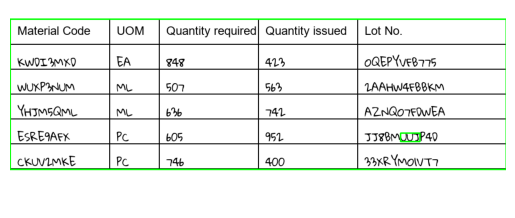

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_001.png"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold and find contours
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 30 and h > 15:  # Filter small noise
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Show
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()







In [42]:
import cv2
import os
import json

# Paths you gave me
images_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs"
labels_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels"
output_path = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_box_labels"

# 4 images to process — change names to your real files
image_names = ["table_001.png", "table_002.png", "table_003.png", "table_004,png"]

os.makedirs(output_path, exist_ok=True)

def extract_cells(image_path):
    img = cv2.imread(image_path, 0)
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))
    horizontal = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
    vertical = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    table_mask = cv2.add(horizontal, vertical)
    contours, _ = cv2.findContours(table_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cells = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:  # tweak if needed
            cells.append((x, y, w, h))

    cells = sorted(cells, key=lambda b: (b[1], b[0]))
    return cells

for img_name in image_names:
    image_path = os.path.join(images_path, img_name)
    label_file_name = img_name.replace(".png", ".txt")
    label_path = os.path.join(labels_path, label_file_name)

    if not os.path.isfile(label_path):
        print(f"❌ Label file not found for {img_name}: {label_path}")
        continue

    with open(label_path, "r", encoding="utf-8") as f:
        lines = [line.strip().split("\t") for line in f.readlines()]
        texts = [item for row in lines for item in row]  # flatten list

    boxes = extract_cells(image_path)

    if len(boxes) != len(texts):
        print(f"⚠️ Warning: Box/Text count mismatch for {img_name} - Boxes: {len(boxes)}, Texts: {len(texts)}")
        continue

    result = []
    for (x, y, w, h), text in zip(boxes, texts):
        box = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]
        result.append([box, text])

    out_file = os.path.join(output_path, label_file_name)
    with open(out_file, "w", encoding="utf-8") as f:
        f.write(json.dumps(result, ensure_ascii=False) + "\n")

    print(f"✅ Processed and saved: {out_file}")


❌ Label file not found for table_001.png: C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels\table_001.txt
❌ Label file not found for table_002.png: C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels\table_002.txt
❌ Label file not found for table_003.png: C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels\table_003.txt
❌ Label file not found for table_004,png: C:\Users\Anant2005\Desktop\HandWriting_recognition\ocr_labels\table_004,png


In [1]:
import os

image_paths = [
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_001.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_002.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_003.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_004.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_005.png"
]

for path in image_paths:
    print(f"{path} => {'FOUND ✅' if os.path.exists(path) else 'NOT FOUND ❌'}")


C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_001.png => FOUND ✅
C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_002.png => FOUND ✅
C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_003.png => FOUND ✅
C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_004.png => FOUND ✅
C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_005.png => FOUND ✅


In [2]:
import cv2
import os
import numpy as np

# Paths
image_paths = [
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_001.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_002.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_003.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_004.png",
    r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Tables_Dataset\table_pngs\table_005.png"
]

output_base_dir = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\Extracted_Cells"
os.makedirs(output_base_dir, exist_ok=True)

def extract_cells(image_path, table_name):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold the image to get binary
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Kernels for detecting lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))

    # Line detection
    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    # Merge lines to form a grid
    grid = cv2.add(horizontal_lines, vertical_lines)

    # Find contours (each cell)
    contours, _ = cv2.findContours(grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 100]

    # Sort top to bottom, then left to right
    boxes = sorted(boxes, key=lambda b: (b[1] // 10, b[0]))

    # Output folder for this table
    table_output_dir = os.path.join(output_base_dir, table_name)
    os.makedirs(table_output_dir, exist_ok=True)

    # Save each cell
    for i, (x, y, w, h) in enumerate(boxes):
        cell = img[y:y+h, x:x+w]
        cv2.imwrite(os.path.join(table_output_dir, f"{table_name}_cell_{i+1}.png"), cell)

# Process each table image
for path in image_paths:
    table_name = os.path.splitext(os.path.basename(path))[0]
    extract_cells(path, table_name)

print(f"✅ All cells extracted and saved in: {output_base_dir}")


✅ All cells extracted and saved in: C:\Users\Anant2005\Desktop\HandWriting_recognition\Extracted_Cells


In [ ]:
# import os

# === CONFIGURE YOUR PATHS ===
labels_dir = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\rec_train_data\labels"
cells_root_dir = r"C:\Users\Anant2005\Desktop\HandWriting_recognition\rec_train_data\cells"
output_train_txt = os.path.join(os.path.dirname(cells_root_dir), "train.txt")

# === SETTINGS ===
rows_per_table = 5
cols_per_row = 5

with open(output_train_txt, "w", encoding="utf-8") as out_file:
    for table_id in range(1, 6):  # table_001 to table_005
        table_name = f"table_{table_id:03d}"
        label_file = os.path.join(labels_dir, f"{table_name}.png.txt")
        cell_folder = os.path.join(cells_root_dir, table_name)

        if not os.path.exists(label_file):
            print(f"⚠️ Label file not found: {label_file}")
            continue

        if not os.path.isdir(cell_folder):
            print(f"⚠️ Cell folder not found: {cell_folder}")
            continue

        # Read label file (skip header)
        with open(label_file, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f if line.strip()][1:]  # ⬅️ Skip header

        if len(lines) != rows_per_table:
            raise ValueError(f"⚠️ {label_file} should have {rows_per_table} data rows, found {len(lines)}.")

        for row_idx, line in enumerate(lines, start=1):
            labels = [cell.strip() for cell in line.split("|")]
            if len(labels) != cols_per_row:
                raise ValueError(f"⚠️ Row {row_idx} in {label_file} should have {cols_per_row} columns. Got: {labels}")

            for col_idx, label in enumerate(labels, start=1):
                img_name = f"{table_name}_cell_{row_idx:02d}_{col_idx:02d}.png"
                rel_img_path = f"./images/{table_name}/{img_name}"  # PaddleOCR format
                out_file.write(f"{rel_img_path}\t{label}\n")

print("✅ train.txt generated successfully at:", output_train_txt)


YMAL folder Creation

In [20]:
yaml_content = """
Global:
  use_gpu: false
  epoch_num: 100
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/rec_custom/
  save_epoch_step: 5
  eval_batch_step: [0, 500]
  cal_metric_during_train: True
  pretrained_model: null
  checkpoints: 
  save_inference_dir:
  use_visualdl: False
  infer_img: doc/imgs_words/en/word_1.png
  character_dict_path: ppocr/utils/en_dict.txt
  max_text_length: 25
  infer_mode: False
  use_space_char: True

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    learning_rate: 0.001
  regularizer:
    name: 'L2'
    factor: 0.0001

Architecture:
  model_type: rec
  algorithm: CRNN
    
    Transform: null

  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: small
    disable_se: True
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 48
  Head:
    name: CTCHead
    fc_decay: 0.0001

Loss:
  name: CTCLoss

PostProcess:
  name: CTCLabelDecode

Metric:
  name: RecMetric
  main_indicator: acc

Train:
  dataset:
    name: SimpleDataSet
    data_dir: C:/Users/Anant2005/Desktop/HandWriting_recognition/rec_train_data/cells
    label_file_list:
      - C:/Users/Anant2005/Desktop/HandWriting_recognition/rec_train_data/train.txt
    transforms:
      - DecodeImage: {img_mode: 'RGB', channel_first: False}
      - RecAug: {}
      - RecResizeImg: {image_shape: [3, 32, 100]}
      - KeepKeys: {keep_keys: ['image', 'label']}
  loader:
    shuffle: True
    batch_size_per_card: 32
    drop_last: True
    num_workers: 2

Eval:
  dataset:
    name: SimpleDataSet
    data_dir: C:/Users/Anant2005/Desktop/HandWriting_recognition/rec_train_data/cells
    label_file_list:
      - C:/Users/Anant2005/Desktop/HandWriting_recognition/rec_train_data/train.txt
    transforms:
      - DecodeImage: {img_mode: 'RGB', channel_first: False}
      - RecResizeImg: {image_shape: [3, 32, 100]}
      - KeepKeys: {keep_keys: ['image', 'label']}
  loader:
    shuffle: False
    drop_last: False
    batch_size_per_card: 32
    num_workers: 2
"""


In [7]:
config_path = "C:/Users/Anant2005/Desktop/HandWriting_recognition/rec_custom.yml"

with open(config_path, "w") as f:
    f.write(yaml_content)

print(f"✅ Config YAML saved at: {config_path}")


NameError: name 'yaml_content' is not defined

In [8]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import random
import string
import os

# Function to generate random values
def random_material_code():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))

def random_uom():
    return random.choice(['ML', 'KG'])

def random_quantity():
    return str(random.randint(10, 999))

def random_lot_no():
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=11))

# Generate a DataFrame
def generate_table_data(rows=5):
    data = []
    for _ in range(rows):
        data.append([
            random_material_code(),
            random_uom(),
            random_quantity(),
            random_quantity(),
            random_lot_no()
        ])
    columns = ['Material Code', 'UOM', 'Quantity Required', 'Quantity Issued', 'Lot No.']
    return pd.DataFrame(data, columns=columns)

# Draw the table
def draw_table(df, filename='generated_table.png'):
    rows, cols = df.shape
    cell_width = 250
    cell_height = 60
    header_height = 70

    img_width = cell_width * cols
    img_height = cell_height * rows + header_height

    # Create image
    image = Image.new('RGB', (img_width, img_height), 'white')
    draw = ImageDraw.Draw(image)

    # Load font
    try:
        font = ImageFont.truetype("arial.ttf", 22)
    except:
        font = ImageFont.load_default()

    # Draw header
    for i, col in enumerate(df.columns):
        x = i * cell_width
        draw.rectangle([x, 0, x + cell_width, header_height], outline='black', width=2)
        draw.text((x + 10, 20), col, fill='black', font=font)

    # Draw cells
    for row in range(rows):
        for col in range(cols):
            x = col * cell_width
            y = row * cell_height + header_height
            draw.rectangle([x, y, x + cell_width, y + cell_height], outline='black', width=1)
            text = str(df.iat[row, col])
            draw.text((x + 10, y + 20), text, fill='black', font=font)

    # Save image
    output_dir = 'generated_tables'
    os.makedirs(output_dir, exist_ok=True)
    image_path = os.path.join(output_dir, filename)
    image.save(image_path)
    print(f"✅ Table image saved to: {image_path}")

# Generate and draw
df = generate_table_data()
draw_table(df)


✅ Table image saved to: generated_tables\generated_table.png


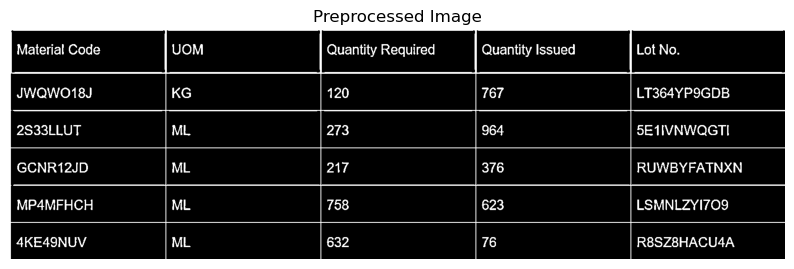

✅ Cleaned image saved at: C:\Users\Anant2005\Desktop\Eugia_Project\cleaned_table.png


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image_path, target_width=1700):
    """
    Preprocess the input image for OCR:
    - Resize to fixed width
    - Convert to grayscale
    - Adaptive thresholding
    - Morphological noise removal
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Resize to fixed width (preserving aspect ratio)
    height, width = img.shape[:2]
    scale = target_width / float(width)
    new_dimensions = (target_width, int(height * scale))
    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_CUBIC)

    # Convert to grayscale
    gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding
    thresholded = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15,
        C=10
    )

    # Morphological operations to remove small noise
    kernel = np.ones((2, 2), np.uint8)
    denoised = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=1)

    return denoised

def display_image(img, title='Preprocessed Image'):
    """Displays the image using matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

def save_image(img, output_path):
    """Saves the image to the given path."""
    cv2.imwrite(output_path, img)
    print(f"✅ Cleaned image saved at: {output_path}")

# ---- EXECUTION ----
input_path = r"C:\Users\Anant2005\Desktop\Eugia_Project\test image\generated_table.png"
output_path = r"C:\Users\Anant2005\Desktop\Eugia_Project\cleaned_table.png"

# Preprocess and save
preprocessed_img = preprocess_image(input_path)
display_image(preprocessed_img)
save_image(preprocessed_img, output_path)


In [12]:
from paddleocr import PaddleOCR
from paddleocr.tools.infer.utility import draw_ocr


# 1. Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Includes angle correction

# 2. Load your cleaned image
image_path = r"C:\Users\Anant2005\Desktop\Eugia_Project\cleaned_table.png"
image = cv2.imread(image_path)

# 3. Run OCR
result = ocr.ocr(image_path, cls=True)

# 4. Extract and print results
print("🔍 OCR Results:")
for line in result:
    for box, (text, confidence) in line:
        print(f"Box: {box}")
        print(f"Text: {text} (Confidence: {confidence:.2f})")
        print("---")

# 5. Draw boxes and text on image
boxes = [elements[0] for elements in result[0]]
txts = [elements[1][0] for elements in result[0]]
scores = [elements[1][1] for elements in result[0]]

# Draw and visualize
image_with_boxes = draw_ocr(image, boxes, txts, scores, font_path='C:/Windows/Fonts/arial.ttf')
plt.figure(figsize=(12, 10))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title("Detected Text and Bounding Boxes")
plt.show()


ModuleNotFoundError: No module named 'paddleocr.tools'

In [14]:
from paddleocr import PaddleOCR
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # angle classifier enabled

# 2. Load cleaned image
image_path = r"C:\Users\Anant2005\Desktop\Eugia_Project\cleaned_table.png"
image = cv2.imread(image_path)

# 3. Run OCR
result = ocr.ocr(image_path)

# 4. Extract OCR results and draw manually
for line in result:
    for box, (text, confidence) in line:
        pts = np.array(box, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image, text, tuple(pts[0][0]), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 1, cv2.LINE_AA)

# 5. Show image with matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("OCR Output with Bounding Boxes")
plt.show()


C:\Users\Anant2005\AppData\Local\Temp\ipykernel_28560\1360486833.py:7: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang='en')  # angle classifier enabled
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('PP-LCNet_x0_25_textline_ori', None)
Using official model (PP-LCNet_x0_25_textline_ori), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('PP-OCRv5_mobile_det', None)
Using official model (PP-OCRv5_mobile_det), the model files will be aut

ValueError: too many values to unpack (expected 2)

In [17]:
from paddleocr import PaddleOCR
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize PaddleOCR (updated deprecated arg)
ocr = PaddleOCR(use_textline_orientation=True, lang='en')  # replacing use_angle_cls

# 2. Load cleaned image
image_path = r"C:\Users\Anant2005\Desktop\Eugia_Project\cleaned_table.png"
image = cv2.imread(image_path)

# 3. Run OCR
result = ocr.ocr(image_path)

# 4. Draw results
for line in result:
    for res in line:
        box = res[0]

        # Handle changing format of OCR result
        if isinstance(res[1], list) and len(res[1]) == 2:
            text, confidence = res[1]
        else:
            text = res[1]
            confidence = None

        pts = np.array(box, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        cv2.putText(image, text, tuple(pts[0][0]), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 0, 255), 1, cv2.LINE_AA)

# 5. Show result
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("OCR Output with Bounding Boxes")
plt.show()



Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('PP-LCNet_x0_25_textline_ori', None)
Using official model (PP-LCNet_x0_25_textline_ori), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('PP-OCRv5_mobile_det', None)
Using official model (PP-OCRv5_mobile_det), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
Creating model: ('PP-OCRv5_mobile_rec', None)
Using official model (PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in C:\Users\Anant2005\.paddlex\official_models.
C:\Users\Anant2005\AppD

ValueError: invalid literal for int() with base 10: 'i'